In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import roc_curve, precision_recall_curve, make_scorer, recall_score, confusion_matrix, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression


rcParams['figure.figsize'] = (8, 8)
rcParams['figure.dpi'] = 150

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

- Funções utilizadas

In [2]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

- Bibliotecas e configurações do pandas e matplotlib

In [3]:
df = pd.read_csv('training_data.csv', sep=';')
df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,25,Travel_Rarely,685,Research & Development,1,3,Life Sciences,1,350,1,Female,62,3,2,Manufacturing Director,3,Married,4898,7505,0,Y,No,12,3,4,80,2,5,3,3,4,2,1,2,0
1,44,Travel_Rarely,1376,Human Resources,1,2,Medical,1,1098,2,Male,91,2,3,Human Resources,1,Married,10482,2326,9,Y,No,14,3,4,80,1,24,1,3,20,6,3,6,1
2,27,Travel_Rarely,135,Research & Development,17,4,Life Sciences,1,1405,4,Female,51,3,1,Research Scientist,3,Single,2394,25681,1,Y,Yes,13,3,4,80,0,8,2,3,8,2,7,7,1
3,40,Travel_Frequently,580,Sales,5,4,Life Sciences,1,729,4,Male,48,2,3,Sales Executive,1,Married,10475,23772,5,Y,Yes,21,4,3,80,1,20,2,3,18,13,1,12,0
4,24,Travel_Rarely,477,Research & Development,24,3,Medical,1,1173,4,Male,49,3,1,Laboratory Technician,2,Single,3597,6409,8,Y,No,22,4,4,80,0,6,2,3,4,3,1,2,0


In [4]:
df['OverTime'] = df['OverTime'].replace({'Yes':1, 'No':0})

In [5]:
cols = ['OverTime', 'JobLevel', 'MonthlyIncome', 'YearsAtCompany', 'Age', 'Attrition']
df = df[cols]

In [6]:
X = df.drop('Attrition', axis=1)
y = df.Attrition

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=51)

In [8]:
print('Training set shape: ', X_train.shape, y_train.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (882, 5) (882,)
Testing set shape:  (294, 5) (294,)


In [9]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
scaler.fit(X_test)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

- Implementando o modelo KNN

In [10]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_scaled, y_train) 

KNeighborsClassifier()

In [11]:
pred_train_knn = model.predict(X_train_scaled)
pred_test_knn = model.predict(X_test_scaled)

In [12]:
cm = confusion_matrix(y_test, pred_test_knn, labels=model.classes_)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

- Otimizando os hiperparâmetros

In [13]:
grid_params = {
    'n_neighbors' : [2, 3, 4, 5, 6, 10, 15],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance'],
}

In [14]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Fitting 15 folds for each of 28 candidates, totalling 420 fits
Best params for recall_score
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}

Confusion matrix of KNN optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       232         8
pos        44        10


In [15]:
grid_search_clf.best_params_

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}

- Modelo Refinado

In [16]:
model = KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='uniform')
model.fit(X_train_scaled, y_train) 

pred_train_knn_refiined = model.predict(X_train_scaled)
pred_test_knn_refined = model.predict(X_test_scaled)

In [17]:
cm2 = confusion_matrix(y_test, pred_test_knn_refined, labels=model.classes_)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=model.classes_)

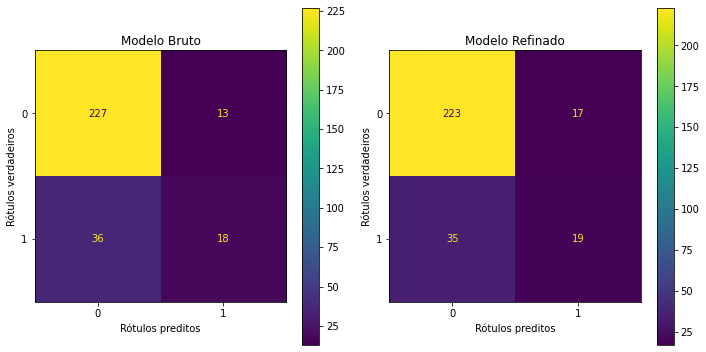

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

disp1.plot(ax=ax1)
disp2.plot(ax=ax2)

ax1.set_title('Modelo Bruto')
ax1.set_xlabel('Rótulos preditos')
ax1.set_ylabel('Rótulos verdadeiros')

ax2.set_title('Modelo Refinado')
ax2.set_xlabel('Rótulos preditos')
ax2.set_ylabel('Rótulos verdadeiros')

fig.tight_layout()

plt.show()

In [19]:
print(f'{"Modelo Bruto":-^60}\n')
print(f'{"Train":-^60}\n{classification_report(y_train, pred_train_knn)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test_knn)}')

------------------------Modelo Bruto------------------------

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       746
           1       0.64      0.31      0.42       136

    accuracy                           0.87       882
   macro avg       0.76      0.64      0.67       882
weighted avg       0.85      0.87      0.85       882


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       240
           1       0.58      0.33      0.42        54

    accuracy                           0.83       294
   macro avg       0.72      0.64      0.66       294
weighted avg       0.81      0.83      0.81       294



In [20]:
print(f'{"Modelo Otimizado":-^60}\n')
print(f'{"Train":-^60}\n{classification_report(y_train, pred_train_knn_refiined)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test_knn_refined)}')

----------------------Modelo Otimizado----------------------

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       746
           1       0.74      0.40      0.52       136

    accuracy                           0.89       882
   macro avg       0.82      0.69      0.73       882
weighted avg       0.88      0.89      0.87       882


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.86      0.93      0.90       240
           1       0.53      0.35      0.42        54

    accuracy                           0.82       294
   macro avg       0.70      0.64      0.66       294
weighted avg       0.80      0.82      0.81       294



- Ajuste do limite (threshold) para separação de classes

In [103]:
y_score = model.predict_proba(X_test_scaled)[:,1] # predict_proba retorna as probabilidades de cada entrada ser de determinada classe

- Fonte: https://towardsdatascience.com/predict-vs-predict-proba-scikit-learn-bdc45daa5972

In [117]:
p, r, thresholds = precision_recall_curve(y_test, y_score) # obtenção dos parâmetros de precisão, recall e limiares

- Fonte: https://towardsdatascience.com/predict-vs-predict-proba-scikit-learn-bdc45daa5972

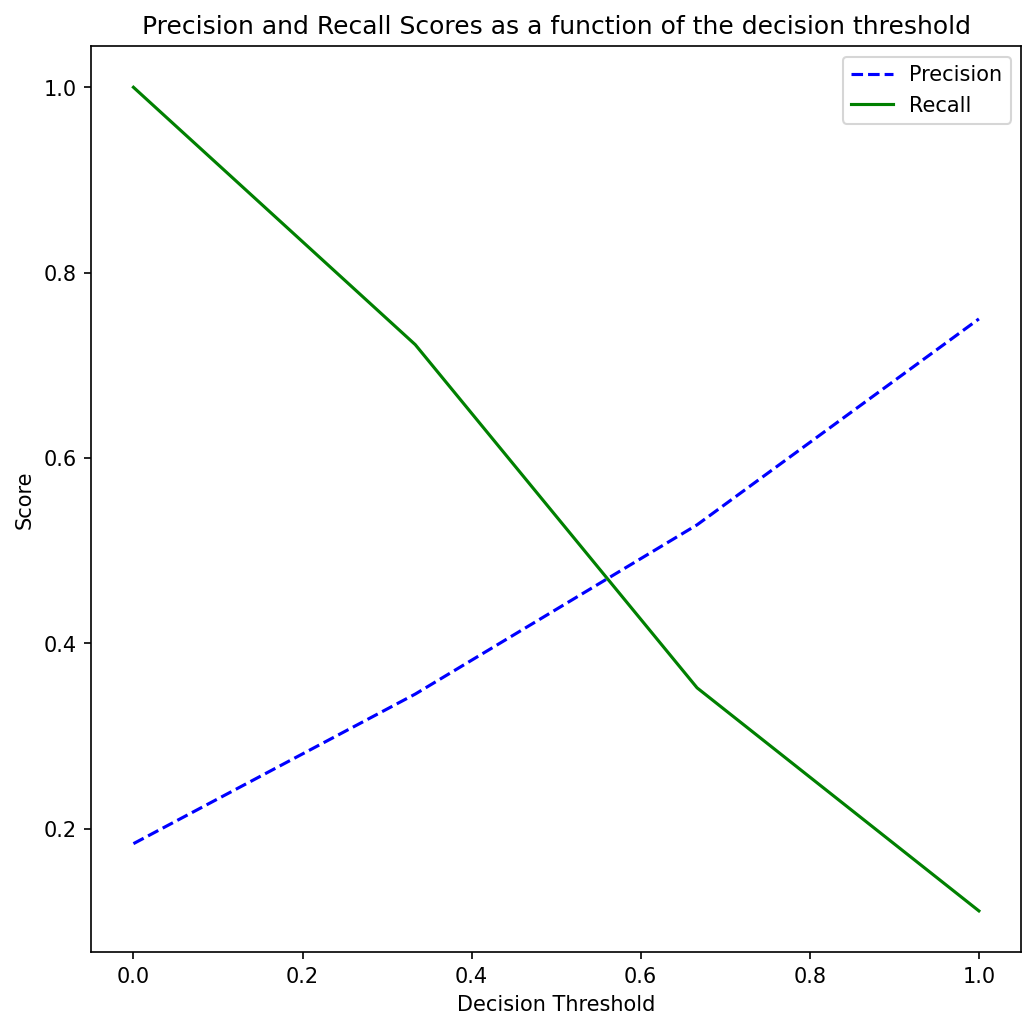

In [115]:
plot_precision_recall_vs_threshold(p, r, thresholds) # Relação da precisão e do recall para diferentes limiares de separação. 

- Fonte: https://www.ibm.com/docs/en/contentclassificatio/8.8?topic=analysis-category-graph-precision-recall-vs-threshold

- Cálculo da área abaixo da curva ROC. Quanto mais próximo de 1 melhor.

0.7380787037037038


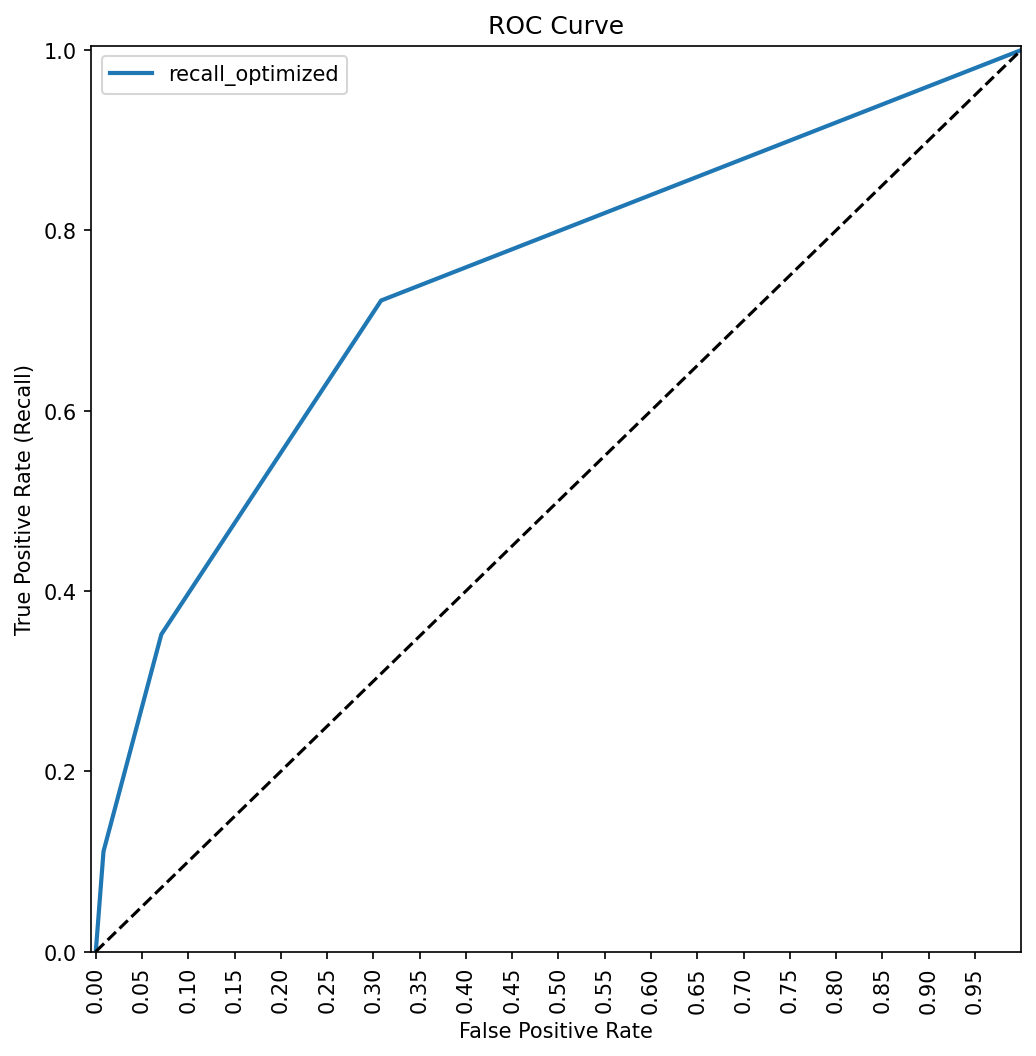

In [116]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_score)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

- Ideal seria a curva em azul

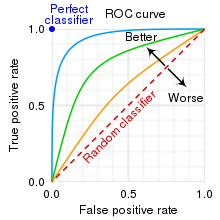

### DATASET BALANCEADO

In [ ]:
df_balanced = pd.read_pickle('balanced_dataset.pkl')
df_balanced.head()

,age,business_travel,daily_rate,department,distance_from_home,education,education_field,environment_satisfaction,gender,hourly_rate,job_involvement,job_level,job_role,job_satisfaction,marital_status,monthly_income,monthly_rate,num_companies_worked,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager,attrition
0,25,2,685,Research & Development,1,3,Life Sciences,1,0,62,3,2,Manufacturing Director,3,Married,34,81,0,0,12,3,4,2,5,3,3,4,2,1,2,0
1,44,2,1376,Human Resources,1,2,Medical,2,1,91,2,3,Human Resources,1,Married,-14,22,9,0,14,3,4,1,24,1,3,20,6,3,6,1
2,27,2,135,Research & Development,17,4,Life Sciences,4,0,51,3,1,Research Scientist,3,Single,90,81,1,1,13,3,4,0,8,2,3,8,2,7,7,1
3,38,2,827,Research & Development,1,4,Life Sciences,2,0,33,4,2,Healthcare Representative,4,Single,-55,-73,0,0,13,3,3,0,10,4,2,9,7,1,8,0
4,47,2,1454,Sales,2,4,Life Sciences,4,0,65,2,1,Sales Representative,4,Single,-34,81,1,1,18,3,1,0,3,3,2,3,2,1,2,0


In [ ]:
df_balanced.attrition.value_counts()

0    692
1    462
Name: attrition, dtype: int64

In [ ]:
df_balanced['over_time'] = df_balanced['over_time'].replace({'Yes':1, 'No':0})

In [ ]:
cols = ['over_time', 'job_level', 'monthly_income', 'years_at_company', 'age', 'attrition']
df_balanced = df_balanced[cols]

In [ ]:
df_balanced

,over_time,job_level,monthly_income,years_at_company,age,attrition
0,0,2,34,4,25,0
1,0,3,-14,20,44,1
2,1,1,90,8,27,1
3,0,2,-55,9,38,0
4,1,1,-34,3,47,0
...,...,...,...,...,...,...
1149,1,2,-77,2,32,1
1150,0,1,73,1,26,1
1151,1,1,110,1,20,1
1152,1,3,85,16,36,1


In [ ]:
X = df_balanced.drop('attrition', axis=1)
y = df_balanced.attrition

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=51)

In [ ]:
print('Training set shape: ', X_train.shape, y_train.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (865, 5) (865,)
Testing set shape:  (289, 5) (289,)


In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
scaler.fit(X_test)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [ ]:
model = KNeighborsClassifier()
model.fit(X_train_scaled, y_train) 

KNeighborsClassifier()

In [ ]:
pred_train_knn = model.predict(X_train_scaled)
pred_test_knn = model.predict(X_test_scaled)

In [ ]:
cm = confusion_matrix(y_test, pred_test_knn, labels=model.classes_)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

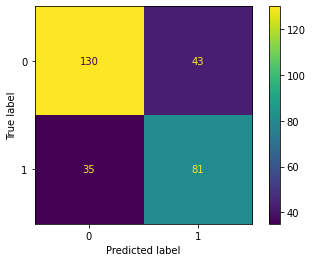

In [ ]:
disp1.plot()

In [ ]:
print(f'{"Modelo Bruto":-^60}\n')
print(f'{"Train":-^60}\n{classification_report(y_train, pred_train_knn)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test_knn)}')

------------------------Modelo Bruto------------------------

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       519
           1       0.76      0.86      0.81       346

    accuracy                           0.84       865
   macro avg       0.83      0.84      0.84       865
weighted avg       0.85      0.84      0.84       865


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       173
           1       0.65      0.70      0.68       116

    accuracy                           0.73       289
   macro avg       0.72      0.72      0.72       289
weighted avg       0.73      0.73      0.73       289



In [ ]:
grid_params = {
    'n_neighbors' : [2, 3, 4, 5, 6, 10, 15],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance'],
}
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Fitting 15 folds for each of 28 candidates, totalling 420 fits
Best params for recall_score
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

Confusion matrix of KNN optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       120        53
pos        21        95


{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [ ]:
best_model = KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='distance')

In [ ]:
best_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(metric='manhattan', weights='distance')

In [ ]:
pred_train_knn_b = best_model.predict(X_train_scaled)
pred_test_knn_b = best_model.predict(X_test_scaled)

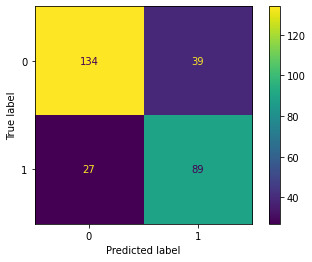

In [ ]:
cm = confusion_matrix(y_test, pred_test_knn_b, labels=best_model.classes_)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp2.plot()

In [ ]:
print(f'{"Modelo Otimizado":-^60}\n')
print(f'{"Train":-^60}\n{classification_report(y_train, pred_train_knn_b)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test_knn_b)}')

----------------------Modelo Otimizado----------------------

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       519
           1       1.00      1.00      1.00       346

    accuracy                           1.00       865
   macro avg       1.00      1.00      1.00       865
weighted avg       1.00      1.00      1.00       865


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       173
           1       0.70      0.77      0.73       116

    accuracy                           0.77       289
   macro avg       0.76      0.77      0.77       289
weighted avg       0.78      0.77      0.77       289



0.770903926649392


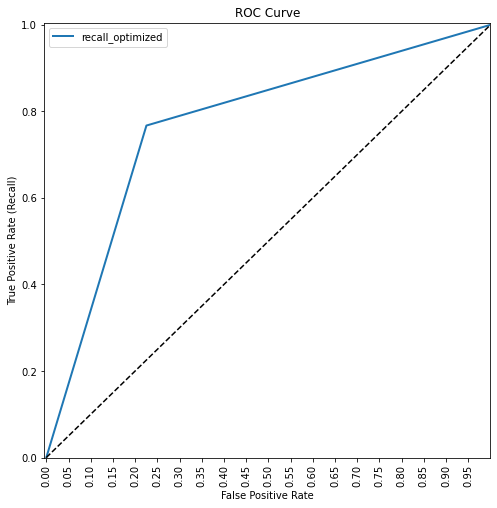

In [ ]:
fpr, tpr, auc_thresholds = roc_curve(y_test, pred_test_knn_b)

print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')


### Random Forest 

In [71]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=51)

forest.fit(X_train_scaled, y_train)

pred_train_rf = forest.predict(X_train_scaled)
pred_test_rf = forest.predict(X_test_scaled)

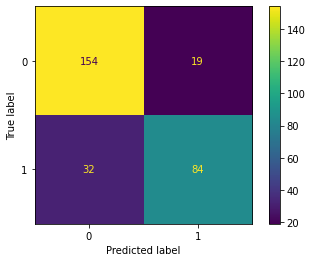

In [72]:
cm = confusion_matrix(y_test, pred_test_rf, labels=forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest.classes_)
disp.plot()

In [73]:
print(f'{"Modelo Bruto":-^60}\n')
print(f'{"Train":-^60}\n{classification_report(y_train, pred_train_rf)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test_rf)}')

------------------------Modelo Bruto------------------------

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       519
           1       1.00      1.00      1.00       346

    accuracy                           1.00       865
   macro avg       1.00      1.00      1.00       865
weighted avg       1.00      1.00      1.00       865


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       173
           1       0.82      0.72      0.77       116

    accuracy                           0.82       289
   macro avg       0.82      0.81      0.81       289
weighted avg       0.82      0.82      0.82       289



In [78]:
grid_params_rf = {
    'n_estimators': [10, 25, 50],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2, 3, 5],
    'max_features': ['sqrt', 'log2', None]
}

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(forest, param_distributions=grid_params_rf, n_iter=20, cv=8, random_state=51, scoring='recall')

random_search.fit(X_train_scaled, y_train)

print('Best parameters:', random_search.best_params_)
print('Best recall:', random_search.best_score_)

Best parameters: {'n_estimators': 50, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'entropy'}
Best recall: 0.5780258985200846


In [79]:
rf_optimal_train = random_search.predict(X_train_scaled)
rf_optimal_test = random_search.predict(X_test_scaled)

In [80]:
print(f'{"Modelo Bruto":-^60}\n')
print(f'{"Train":-^60}\n{classification_report(y_train, rf_optimal_train)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, rf_optimal_test)}')

------------------------Modelo Bruto------------------------

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       519
           1       0.83      0.65      0.73       346

    accuracy                           0.81       865
   macro avg       0.81      0.78      0.79       865
weighted avg       0.81      0.81      0.80       865


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       173
           1       0.82      0.61      0.70       116

    accuracy                           0.79       289
   macro avg       0.80      0.76      0.77       289
weighted avg       0.79      0.79      0.78       289



- Logistic Regression

In [81]:
log = LogisticRegression()
log.fit(X_train_scaled, y_train)

pred_train_log = log.predict(X_train_scaled)
pred_test_log = log.predict(X_test_scaled)

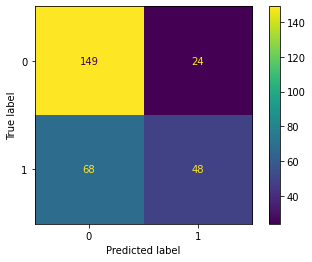

In [82]:
cm = confusion_matrix(y_test, pred_test_log, labels=log.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log.classes_)
disp.plot()

In [83]:
print(f'{"Modelo Bruto":-^60}\n')
print(f'{"Train":-^60}\n{classification_report(y_train, pred_train_log)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test_log)}')

------------------------Modelo Bruto------------------------

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       519
           1       0.67      0.46      0.55       346

    accuracy                           0.69       865
   macro avg       0.69      0.66      0.66       865
weighted avg       0.69      0.69      0.68       865


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.69      0.86      0.76       173
           1       0.67      0.41      0.51       116

    accuracy                           0.68       289
   macro avg       0.68      0.64      0.64       289
weighted avg       0.68      0.68      0.66       289

